In [1]:
import os
import sys
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/notebooks/reports/"))
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
import util
import motif.match_motifs as match_motifs
import motif.read_motifs as read_motifs
import plot.viz_sequence as viz_sequence
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import sklearn.cluster
import scipy.cluster.hierarchy

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold",
    "svg.fonttype": "none"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
out_path = "/users/amtseng/tfmodisco/figures/reports_pipeline"
os.makedirs(out_path, exist_ok=True)

In [4]:
results_base = "/users/amtseng/tfmodisco/results/"

motif_file_path = os.path.join(results_base, "motifs/tfmodisco/SPI1_tfmodisco_cpmerged_motifs.h5")

seqlets_file_path = os.path.join(
    results_base,
    "reports/tfmodisco_results/cache",
    "multitask_profile_finetune/E2F6_multitask_profile_finetune_fold1/E2F6_multitask_profile_finetune_fold1_profile/0_1_seqlets.npz"
)

tomtom_query_path = os.path.join(
    results_base,
    "reports/tfmodisco_results/cache",
    "multitask_profile_finetune/FOXA2_multitask_profile_finetune_fold7/FOXA2_multitask_profile_finetune_fold7_profile",
    "tomtom/metacluster_0/query_motifs.txt"
)
tomtom_results_path = os.path.join(
    results_base,
    "reports/tfmodisco_results/cache",
    "multitask_profile_finetune/FOXA2_multitask_profile_finetune_fold7/FOXA2_multitask_profile_finetune_fold7_profile",
    "tomtom/metacluster_0/tomtom/tomtom.tsv"
)
tomtom_database = match_motifs.import_database_pfms(match_motifs.DATABASE_PATH)

motif_subclusters_path = os.path.join(
    results_base,
    "reports/motif_clustering/cache",
    "multitask_profile_finetune/E2F6_multitask_profile_finetune_fold1/E2F6_multitask_profile_finetune_fold1_profile",
    "all_motif_subclusters.h5"
)

heatmap_file_path = os.path.join(
    results_base,
    "reports/motif_heatmaps/cache",
    "multitask_profile_finetune/SPI1_multitask_profile_finetune_task0/motif_clusters.h5"
)

cooccurrence_tfm_path = os.path.join(
    results_base,
    "tfmodisco/BPNet/BPNet_Nanog_ChIPseq/BPNet_Nanog_ChIPseq_profile_tfm.h5"
)
cooccurrence_file_path = os.path.join(
    results_base,
    "reports/motif_hits/cache/tfm",
    "BPNet/BPNet_Nanog_ChIPseq/BPNet_Nanog_ChIPseq_profile",
    "cooccurrences.h5"
)
cooccurrence_dist_path = os.path.join(
    results_base,
    "reports/motif_hits/cache/tfm",
    "BPNet/BPNet_Nanog_ChIPseq/BPNet_Nanog_ChIPseq_profile",
    "intermotif_dists.h5"
)

### Motif representations

In [5]:
with h5py.File(motif_file_path, "r") as f:
    motif_dset = f["multitask_finetune"]["task_agg"]["C0_0:P0_0"]
    pfm = motif_dset["pfm_trimmed"][:]
    cwm = motif_dset["cwm_trimmed"][:]
    hcwm = motif_dset["hcwm_trimmed"][:]

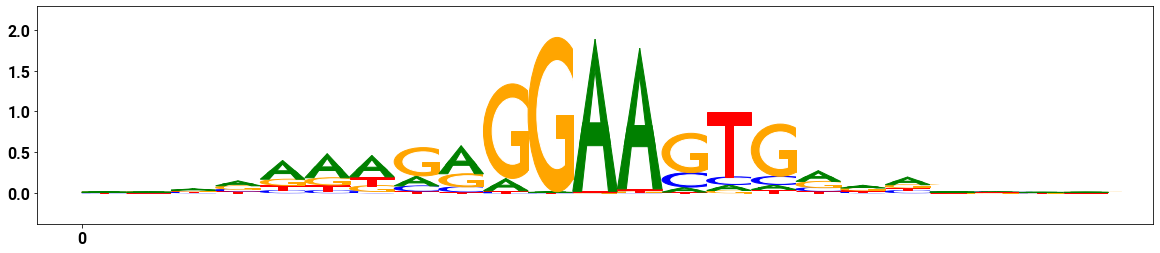

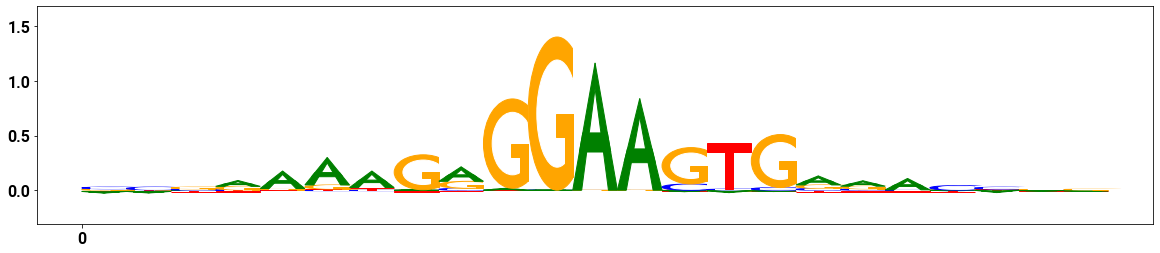

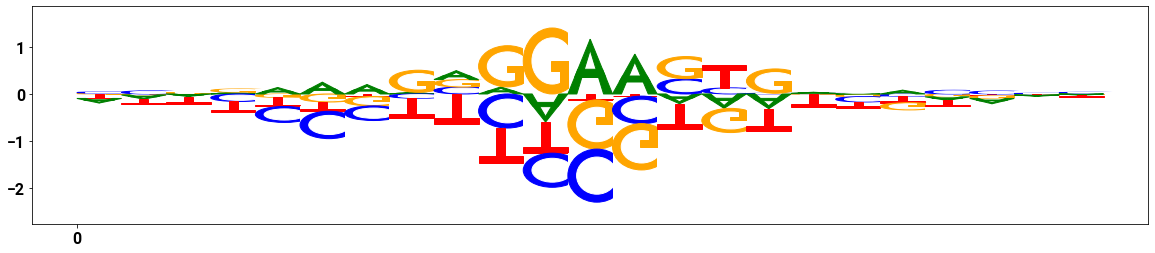

In [6]:
pwm_fig = viz_sequence.plot_weights(read_motifs.pfm_to_pwm(pfm), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "motif_repr_pwm.svg"),
    format="svg"
)
cwm_fig = viz_sequence.plot_weights(cwm, subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "motif_repr_cwm.svg"),
    format="svg"
)
hcwm_fig = viz_sequence.plot_weights(hcwm, subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "motif_repr_hcwm.svg"),
    format="svg"
)
plt.show()

### Profile footprints

In [7]:
seqlet_dict = np.load(seqlets_file_path)

In [8]:
true_profs = seqlet_dict["seqlet_true_profs"]
pred_profs = seqlet_dict["seqlet_pred_profs"]

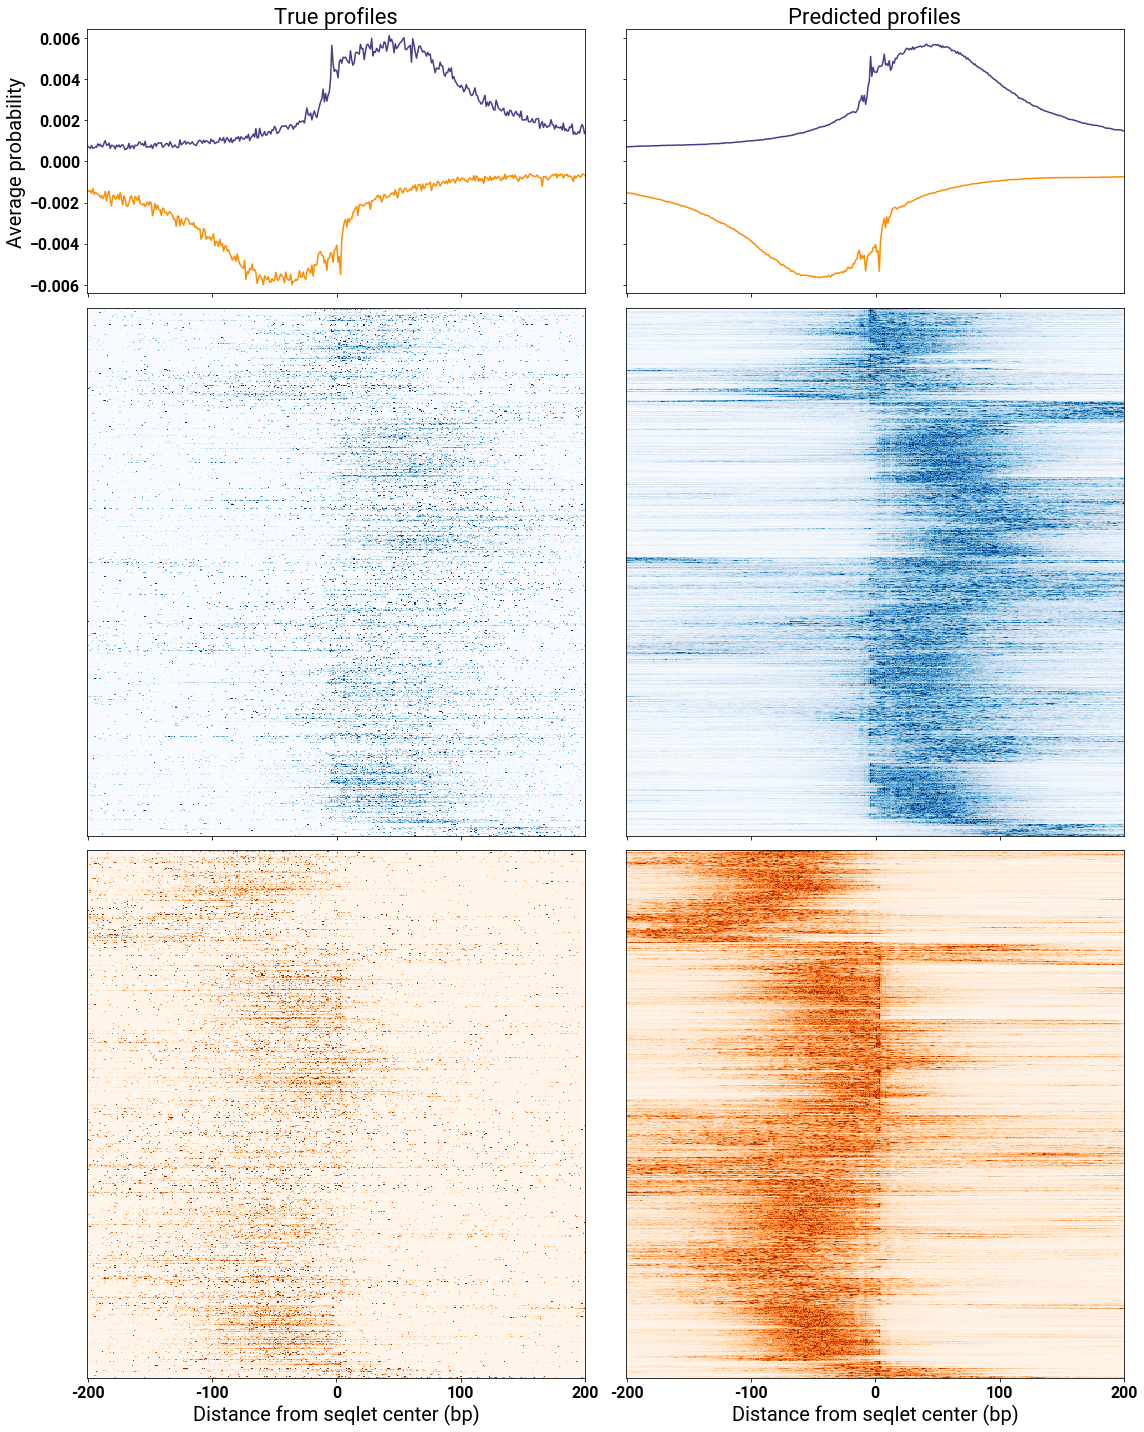

In [9]:
seqlet_true_profs = np.reshape(true_profs, (-1, true_profs.shape[2], true_profs.shape[3]))
seqlet_pred_profs = np.reshape(pred_profs, (-1, pred_profs.shape[2], pred_profs.shape[3]))

assert len(seqlet_true_profs.shape) == 3
assert seqlet_true_profs.shape == seqlet_pred_profs.shape
num_profs, width, _ = seqlet_true_profs.shape

# First, normalize the profiles along the output profile dimension
def normalize(arr, axis=0):
    arr_sum = np.sum(arr, axis=axis, keepdims=True)
    arr_sum[arr_sum == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
    return arr / arr_sum
true_profs_norm = normalize(seqlet_true_profs, axis=1)
pred_profs_norm = normalize(seqlet_pred_profs, axis=1)

# Compute the mean profiles across all examples
true_profs_mean = np.mean(true_profs_norm, axis=0)
pred_profs_mean = np.mean(pred_profs_norm, axis=0)

# Perform k-means clustering on the predicted profiles, with the strands pooled
kmeans_clusters = max(5, num_profs // 50)  # Set number of clusters based on number of profiles, with minimum
kmeans = sklearn.cluster.KMeans(n_clusters=kmeans_clusters)
cluster_assignments = kmeans.fit_predict(
    np.reshape(pred_profs_norm, (pred_profs_norm.shape[0], -1))
)

# Perform hierarchical clustering on the cluster centers to determine optimal ordering
kmeans_centers = kmeans.cluster_centers_
cluster_order = scipy.cluster.hierarchy.leaves_list(
    scipy.cluster.hierarchy.optimal_leaf_ordering(
        scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
    )
)

# Order the profiles so that the cluster assignments follow the optimal ordering
cluster_inds = []
for cluster_id in cluster_order:
    cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
cluster_inds = np.concatenate(cluster_inds)

# Compute a matrix of profiles, normalized to the maximum height, ordered by clusters
def make_profile_matrix(flat_profs, order_inds):
    matrix = flat_profs[order_inds]
    maxes = np.max(matrix, axis=1, keepdims=True)
    maxes[maxes == 0] = 1  # If 0, keep 0 as the quotient instead of dividing by 0
    return matrix / maxes
true_matrix = make_profile_matrix(true_profs_norm, cluster_inds)
pred_matrix = make_profile_matrix(pred_profs_norm, cluster_inds)

# Create a figure with the right dimensions
mean_height = 4
heatmap_height = min(num_profs * 0.004, 8)
fig_height = mean_height + (2 * heatmap_height)
fig, ax = plt.subplots(
    3, 2, figsize=(16, fig_height), sharex=True,
    gridspec_kw={
        "width_ratios": [1, 1],
        "height_ratios": [mean_height / fig_height, heatmap_height / fig_height, heatmap_height / fig_height]
    }
)

# Plot the average predictions
ax[0, 0].plot(true_profs_mean[:, 0], color="darkslateblue")
ax[0, 0].plot(-true_profs_mean[:, 1], color="darkorange")
ax[0, 1].plot(pred_profs_mean[:, 0], color="darkslateblue")
ax[0, 1].plot(-pred_profs_mean[:, 1], color="darkorange")

# Set axes on average predictions
max_mean_val = max(np.max(true_profs_mean), np.max(pred_profs_mean))
mean_ylim = max_mean_val * 1.05  # Make 5% higher
ax[0, 0].set_title("True profiles")
ax[0, 0].set_ylabel("Average probability")
ax[0, 1].set_title("Predicted profiles")
for j in (0, 1):
    ax[0, j].set_ylim(-mean_ylim, mean_ylim)
    ax[0, j].label_outer()

# Plot the heatmaps
ax[1, 0].imshow(true_matrix[:, :, 0], interpolation="nearest", aspect="auto", cmap="Blues")
ax[1, 1].imshow(pred_matrix[:, :, 0], interpolation="nearest", aspect="auto", cmap="Blues")
ax[2, 0].imshow(true_matrix[:, :, 1], interpolation="nearest", aspect="auto", cmap="Oranges")
ax[2, 1].imshow(pred_matrix[:, :, 1], interpolation="nearest", aspect="auto", cmap="Oranges")

# Set axes on heatmaps
for i in (1, 2):
    for j in (0, 1):
        ax[i, j].set_yticks([])
        ax[i, j].set_yticklabels([])
        ax[i, j].label_outer()
width = true_matrix.shape[1]
delta = 100
num_deltas = (width // 2) // delta
labels = list(range(max(-width // 2, -num_deltas * delta), min(width // 2, num_deltas * delta) + 1, delta))
tick_locs = [label + max(width // 2, num_deltas * delta) for label in labels]
for j in (0, 1):
    ax[2, j].set_xticks(tick_locs)
    ax[2, j].set_xticklabels(labels)
    ax[2, j].set_xlabel("Distance from seqlet center (bp)")

fig.tight_layout()
plt.savefig(
    os.path.join(out_path, "profile_footprints.svg"),
    format="svg"
)
plt.show()

### Summit distance distribution

In [10]:
summit_dists = seqlet_dict["summit_dists"]

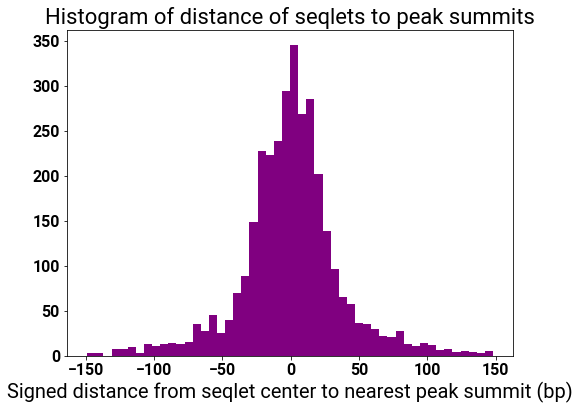

In [11]:
fig = plt.figure(figsize=(8, 6))
num_bins = 50
plt.hist(summit_dists, bins=num_bins, color="purple")
plt.title("Histogram of distance of seqlets to peak summits")
plt.xlabel("Signed distance from seqlet center to nearest peak summit (bp)")
plt.savefig(
    os.path.join(out_path, "summit_dists.svg"),
    format="svg"
)
plt.show()

### TOMTOM matches

In [12]:
# Import motif of interest
motif_index = 0
with open(tomtom_query_path, "r") as f:
    for line in f:
        if line.strip() == "MOTIF %d" % motif_index:
            motif = []
            next(f)  # Get rid of header
            line = next(f).strip()
            while line:
                motif.append(np.array([float(x) for x in line.split()]))
                line = next(f).strip()
            break
query_motif = np.stack(motif)

In [13]:
# Import TOMTOM hits
tomtom_hits = pd.read_csv(tomtom_results_path, sep="\t", header=0, index_col=False)

FOXA2_HUMAN.H11MO.0.A (q-val = 4.27873e-08)


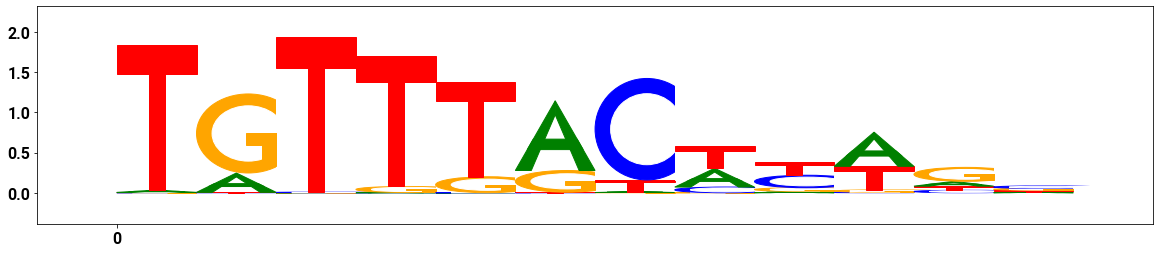

FOXA3_HUMAN.H11MO.0.B (q-val = 4.27873e-08)


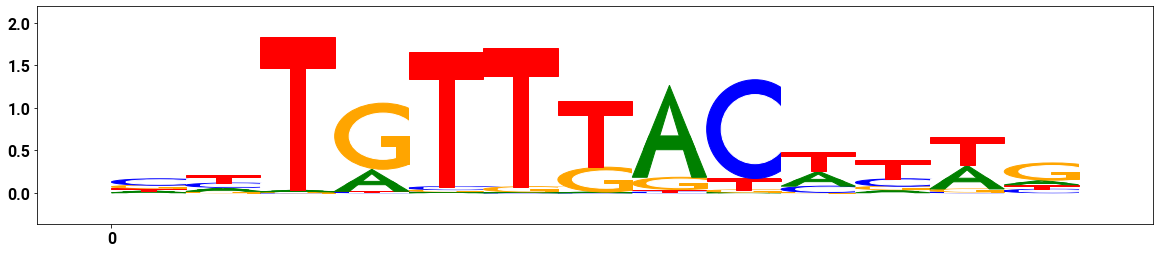

FOXA1_HUMAN.H11MO.0.A (q-val = 5.7918900000000005e-08)


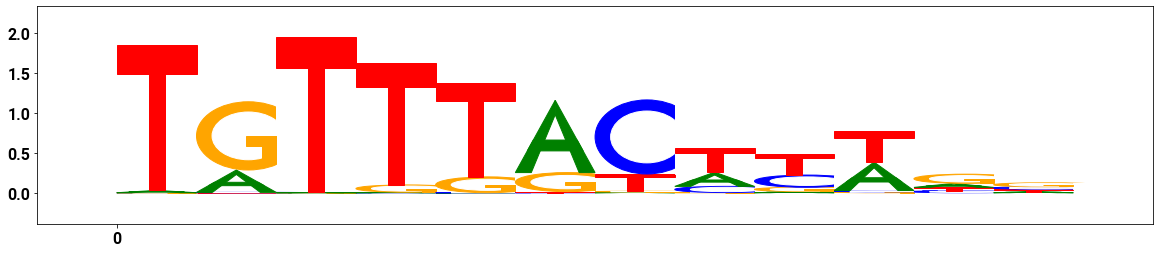

MA0846.1_FOXC2 (q-val = 1.03317e-07)


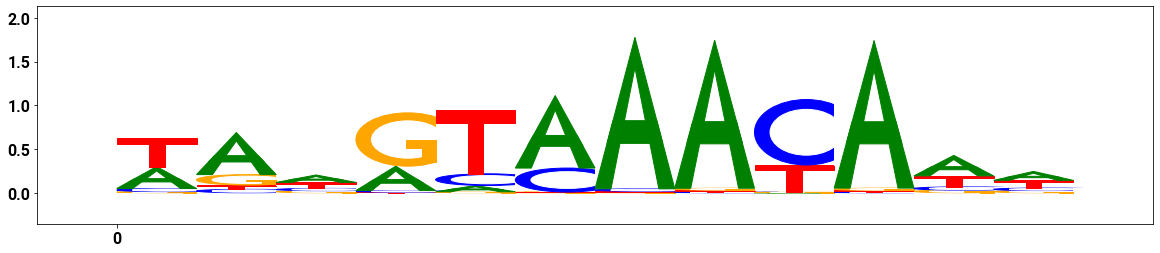

MA0032.2_FOXC1 (q-val = 2.42152e-07)


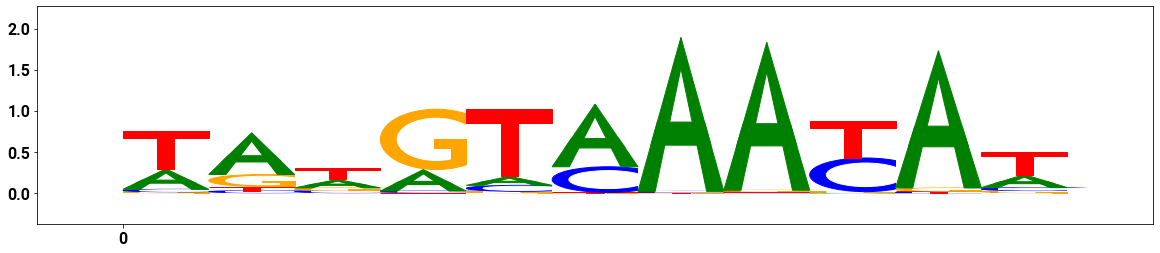

In [14]:
for i, row in tomtom_hits[tomtom_hits["Query_ID"] == str(motif_index)].head(5).reset_index().iterrows():
    match_id, q_val = row["Target_ID"], row["q-value"]
    print("%s (q-val = %s)" % (match_id, q_val))
    match_motif = tomtom_database[match_id]
    match_fig = viz_sequence.plot_weights(read_motifs.pfm_to_pwm(match_motif), subticks_frequency=100, figsize=(20, 4), return_fig=True)
    plt.savefig(
        os.path.join(out_path, "tomtom_match_%d.svg" % i),
        format="svg"
    )
    plt.show()

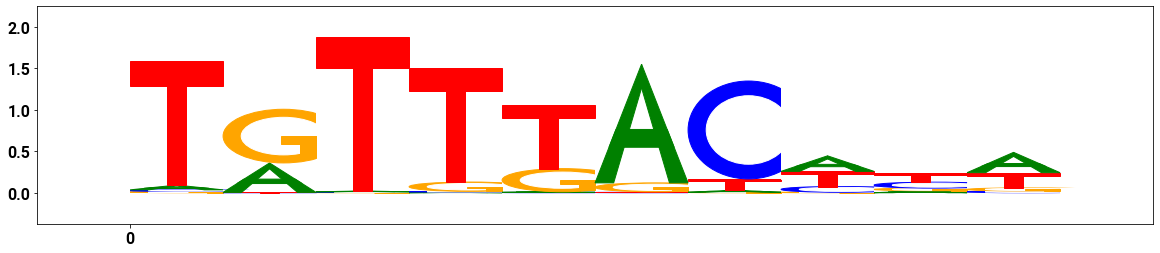

In [15]:
query_fig = viz_sequence.plot_weights(read_motifs.pfm_to_pwm(query_motif), subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "tomtom_query.svg"),
    format="svg"
)
plt.show()

### Intramotif heterogeneity

In [16]:
motif_key = "0_0"

sub_motifs = []
with h5py.File(motif_subclusters_path, "r") as f:
    embeddings = f[motif_key]["embeddings"][:]
    clusters = f[motif_key]["clusters"][:]
    for sub_key in f[motif_key]:
        if sub_key.startswith("subcluster_"):
            sub_motifs.append(f[motif_key][sub_key]["hcwm_trimmed"][:])

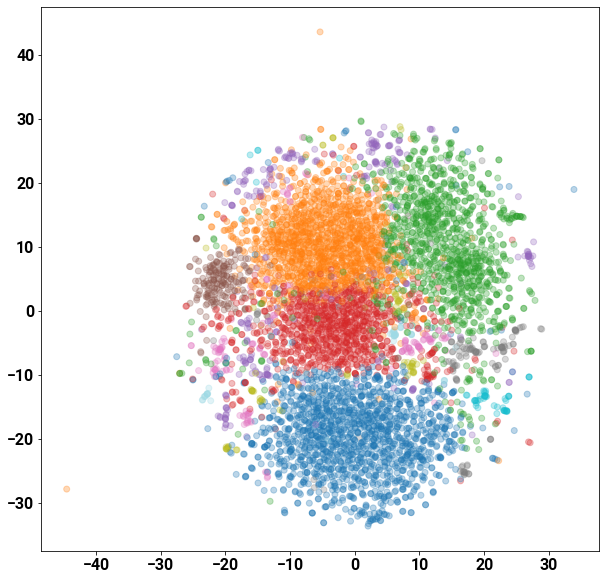

In [17]:
emb_fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    embeddings[:,0], embeddings[:,1], c=clusters, cmap="tab20", alpha=0.3
)
plt.savefig(
    os.path.join(out_path, "subcluster_embeddings.svg"),
    format="svg"
)
plt.show()

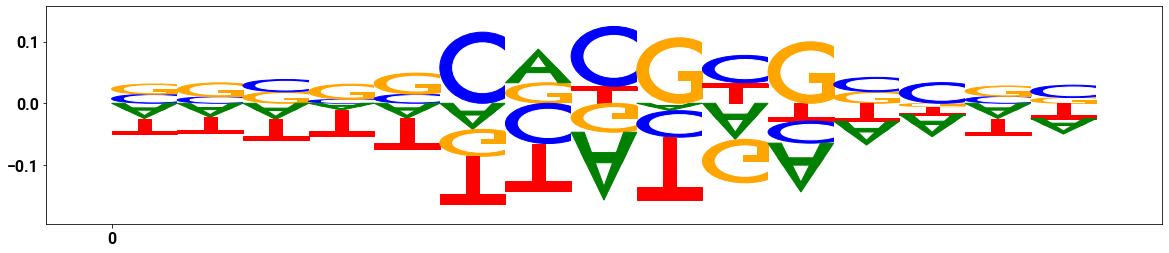

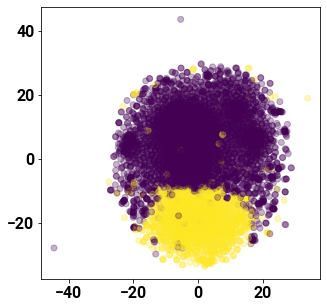

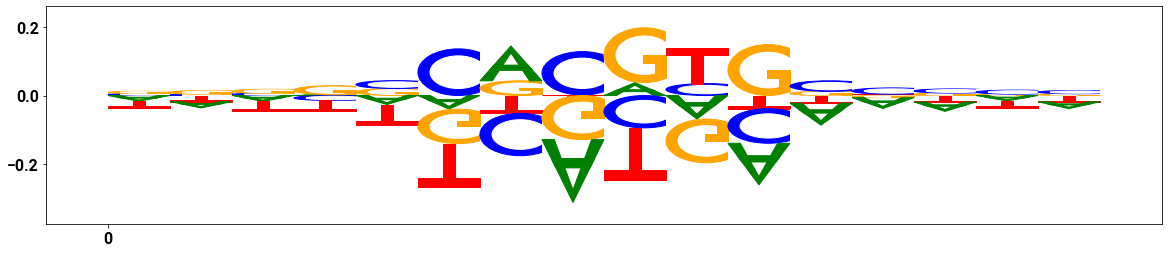

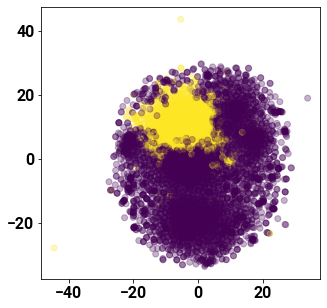

In [18]:
subcluster_inds = [0, 1]
for i in subcluster_inds:
    sub_motif_fig = viz_sequence.plot_weights(sub_motifs[i], subticks_frequency=100, figsize=(20, 4), return_fig=True)
    plt.savefig(
        os.path.join(out_path, "subcluster_hcwm_%d.svg" % i),
        format="svg"
    )
    plt.show()
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(
        embeddings[:,0], embeddings[:,1], c=(clusters == i), alpha=0.3
    )
    plt.show()

### Intermotif heterogeneity

In [19]:
with h5py.File(heatmap_file_path, "r") as f:
    dendrogram_order = f["dendrogram_order"][:]
    sim_matrix = f["similarity_matrix"][:]
    labels = list(f["all_motifs"].keys())
    motifs = [f["all_motifs"][label][:] for label in labels]

In [20]:
def compute_clusters(linkage, goal_clusters, tolerance=(-2, 2), start=50, max_iter=10):
    """
    From a linkage map, computes clusters with a goal of `goal_clusters` clusters.
    Will allow the given tolerance. `start` is what distance threshold to check first.
    `max_iter` is the maximum number of checks to do.
    Returns the clustering.
    """
    clusters = scipy.cluster.hierarchy.fcluster(
        linkage, start, criterion="distance"
    )
    
    num_clusters = len(np.unique(clusters))
    if num_clusters > goal_clusters + tolerance[1] and max_iter:
        return compute_clusters(linkage, goal_clusters, tolerance, start * 2, max_iter - 1)
    elif num_clusters < goal_clusters - tolerance[0] and max_iter:
        return compute_clusters(linkage, goal_clusters, tolerance, start / 2, max_iter - 1)
    else:
        return clusters

In [21]:
linkage = scipy.cluster.hierarchy.linkage(sim_matrix, method="ward")
expected_clusters = 12
clusters = compute_clusters(linkage, expected_clusters, max_iter=100)

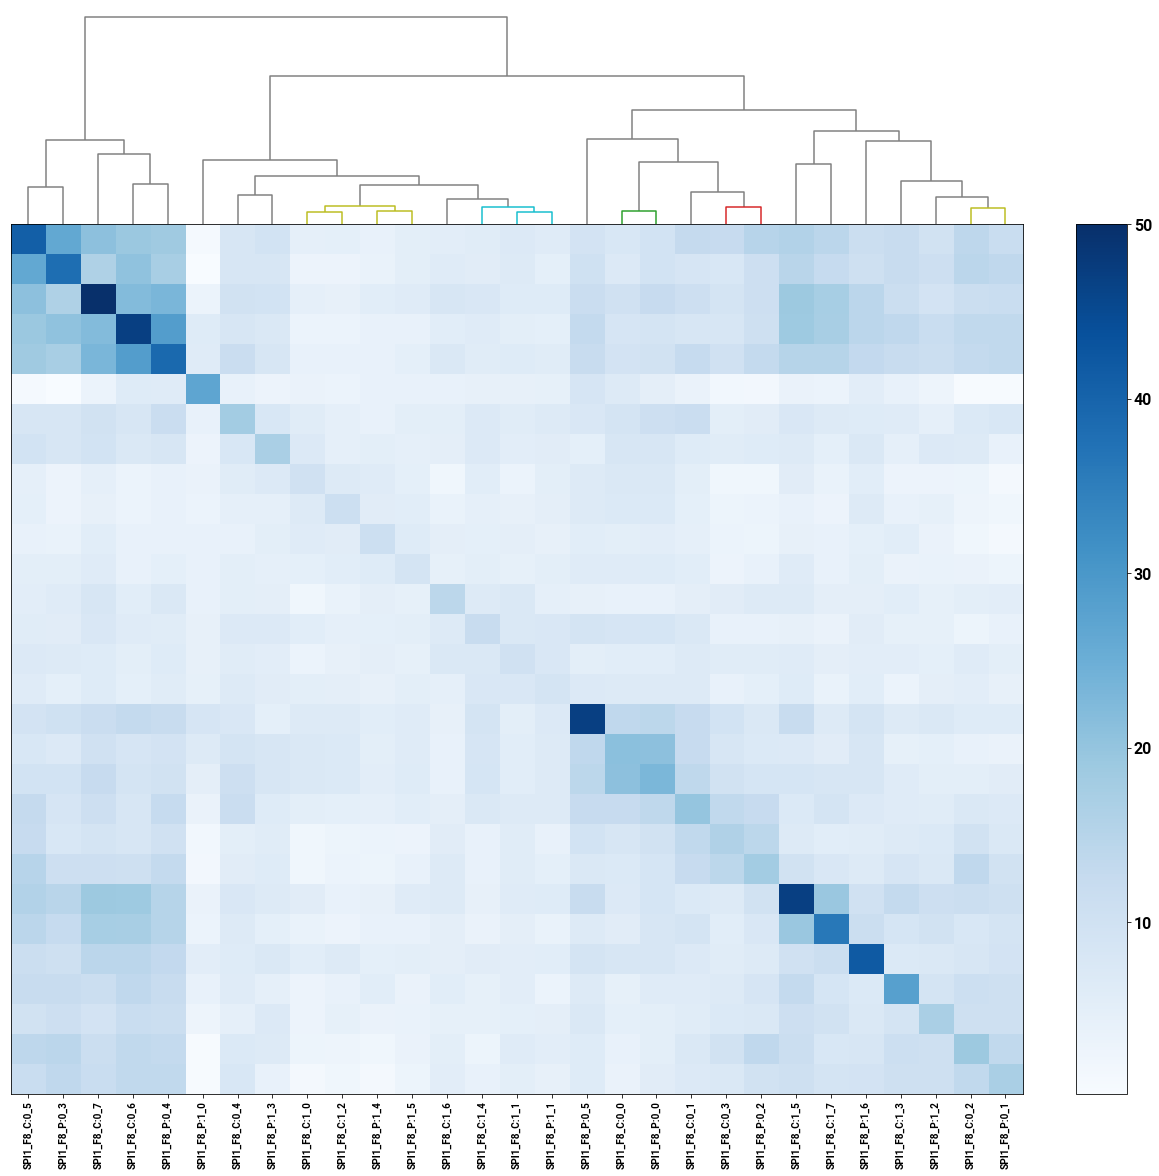

In [22]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(20, 20),
    gridspec_kw={
        "width_ratios": [20, 1],
        "height_ratios": [1, 4],
        "hspace": 0,
        "wspace": 0.1
    }
)

cluster_color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
default_cluster_color = "gray"

# Compute the color of every link based on cluster assignments
# Adapted from https://stackoverflow.com/questions/38153829/custom-cluster-colors-of-scipy-dendrogram-in-python-link-color-func
leaf_colors = [cluster_color_cycle[i % len(cluster_color_cycle)] for i in clusters]
link_colors = {}
for i, i_link in enumerate(linkage[:, :2].astype(int)):
    color_0 = link_colors[i_link[0]] if i_link[0] > len(linkage) else leaf_colors[i_link[0]]
    color_1 = link_colors[i_link[1]] if i_link[1] > len(linkage) else leaf_colors[i_link[1]]
    link_colors[i + 1 + len(linkage)] = color_0 if color_0 == color_1 else default_cluster_color

dend = scipy.cluster.hierarchy.dendrogram(
    linkage, ax=ax[0, 0], link_color_func=(lambda x: link_colors[x])
)

order_inds = dend["leaves"]
sim_matrix_reordered = sim_matrix[:, order_inds][order_inds, :]
heatmap = ax[1, 0].imshow(sim_matrix_reordered, aspect="auto", cmap="Blues")
ax[1, 0].set_yticks([])
ax[1, 0].set_xticks(range(len(sim_matrix)))
ax[1, 0].set_xticklabels(np.array(labels)[order_inds], rotation=90, fontsize=10)

fig.colorbar(heatmap, cax=ax[1, 1])

ax[0, 0].axis("off")
ax[0, 1].axis("off")

plt.savefig(
    os.path.join(out_path, "motif_heatmap.svg"),
    format="svg"
)
plt.show()

SPI1_F8_C:0_0


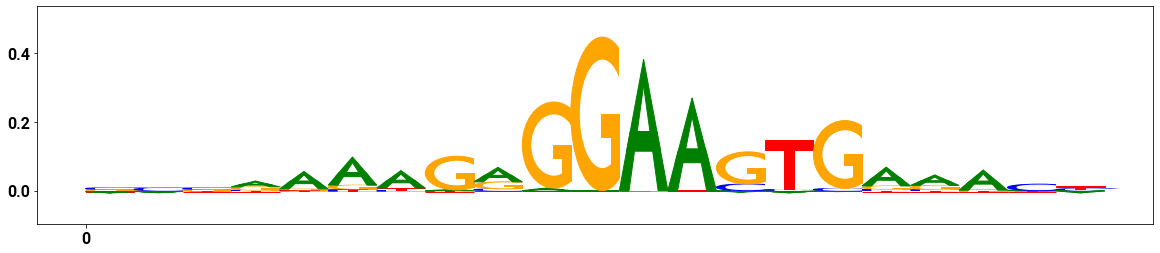

SPI1_F8_C:0_1


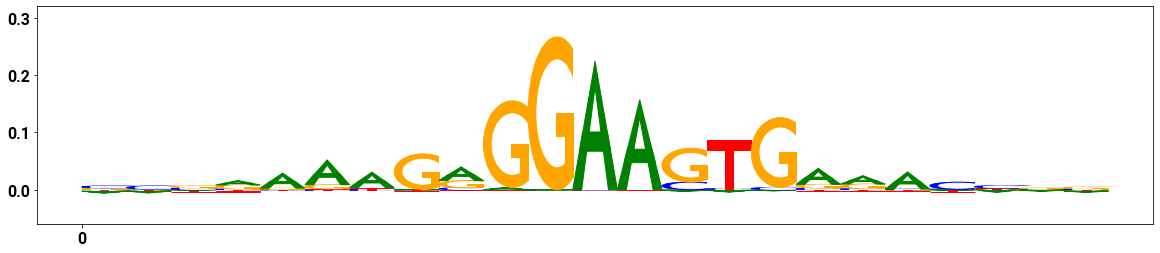

Aggregate


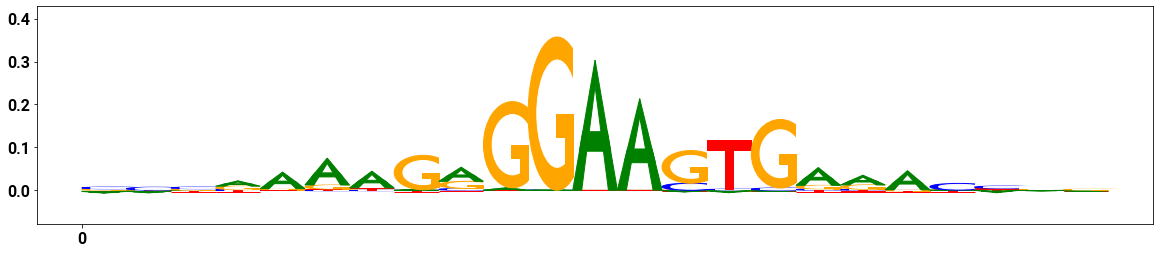

In [23]:
cluster_id = 12
match_inds = np.where(clusters == cluster_id)[0]

matches = [motifs[i] for i in match_inds]
for i, match in enumerate(matches):
    print(labels[i])
    match_fig = viz_sequence.plot_weights(match, subticks_frequency=100, figsize=(20, 4), return_fig=True)
    plt.savefig(
        os.path.join(out_path, "motif_heatmap_const_%d.svg" % i),
        format="svg"
    )
    plt.show()
print("Aggregate")
agg = util.aggregate_motifs(matches)
agg_fig = viz_sequence.plot_weights(agg, subticks_frequency=100, figsize=(20, 4), return_fig=True)
plt.savefig(
    os.path.join(out_path, "motif_heatmap_agg.svg"),
    format="svg"
)
plt.show()

### Co-occurrence heatmap

In [24]:
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the PFMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    pfms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]
                pfm = pattern["sequence"]["fwd"][:]
                cwm = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if only_pos and np.sum(cwm) < 0:
                    continue
                    
                if trim:
                    pfm = read_motifs.trim_motif_by_ic(pfm, pfm)
                    
                pfms["%d_%d" % (metacluster_i,pattern_i)] = pfm
    return pfms

In [25]:
# Import the PFMs
pfms = import_tfmodisco_motifs(cooccurrence_tfm_path)
motif_keys = list(pfms.keys())

In [26]:
with h5py.File(cooccurrence_file_path, "r") as f:
    pval_matrix = f["pvals"][:]

In [27]:
def cluster_matrix_indices(matrix, num_clusters):
    """
    Clusters matrix using k-means. Always clusters on the first
    axis. Returns the indices needed to optimally order the matrix
    by clusters.
    """
    if len(matrix) == 1:
        # Don't cluster at all
        return np.array([0])

    num_clusters = min(num_clusters, len(matrix))
    
    # Perform k-means clustering
    kmeans = sklearn.cluster.MiniBatchKMeans(n_clusters=num_clusters)
    cluster_assignments = kmeans.fit_predict(matrix)

    # Perform hierarchical clustering on the cluster centers to determine optimal ordering
    kmeans_centers = kmeans.cluster_centers_
    cluster_order = scipy.cluster.hierarchy.leaves_list(
        scipy.cluster.hierarchy.optimal_leaf_ordering(
            scipy.cluster.hierarchy.linkage(kmeans_centers, method="centroid"), kmeans_centers
        )
    )

    # Order the peaks so that the cluster assignments follow the optimal ordering
    cluster_inds = []
    for cluster_id in cluster_order:
        cluster_inds.append(np.where(cluster_assignments == cluster_id)[0])
    cluster_inds = np.concatenate(cluster_inds)
    return cluster_inds

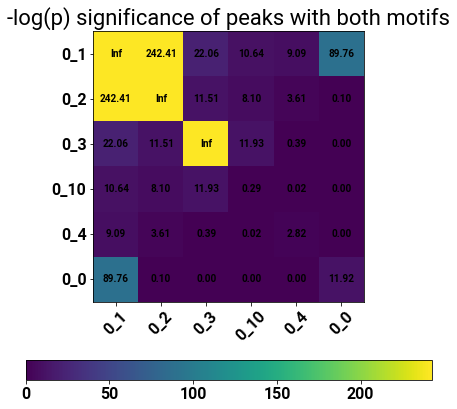

In [28]:
top_k = 6  # Only show top pairs

# Cluster by p-value
num_motifs = len(pval_matrix)
inds = cluster_matrix_indices(pval_matrix, max(5, num_motifs // 4))
pval_matrix_ordered = pval_matrix[inds][:, inds]
motif_keys_ordered = np.array(motif_keys)[inds]

# Plot the p-value matrix

fig_width = max(5, top_k)
p_fig, ax = plt.subplots(figsize=(fig_width, fig_width))

# Replace 0s with minimum value (we'll label them properly later)
zero_mask = pval_matrix_ordered == 0
non_zeros = pval_matrix_ordered[~zero_mask]
if not len(non_zeros):
    logpval_matrix = np.tile(np.inf, pval_matrix_ordered.shape)
else:
    min_val = np.min(pval_matrix_ordered[~zero_mask])
    pval_matrix_ordered[zero_mask] = min_val
    logpval_matrix = -np.log10(pval_matrix_ordered)

hmap = ax.imshow(logpval_matrix[:top_k, :top_k])

ax.set_xticks(np.arange(top_k))
ax.set_yticks(np.arange(top_k))
ax.set_xticklabels(motif_keys_ordered[:top_k], rotation=45)
ax.set_yticklabels(motif_keys_ordered[:top_k])

# Loop over data dimensions and create text annotations.
for i in range(top_k):
    for j in range(top_k):
        if zero_mask[i, j]:
            text = "Inf"
        else:
            text = "%.2f" % np.abs(logpval_matrix[i, j])
        ax.text(j, i, text, ha="center", va="center")
p_fig.colorbar(hmap, orientation="horizontal")

ax.set_title("-log(p) significance of peaks with both motifs")
p_fig.tight_layout()

plt.savefig(
    os.path.join(out_path, "cooccur_heatmap.svg"),
    format="svg"
)
plt.show()

### Co-occurrence distances

In [29]:
with h5py.File(cooccurrence_dist_path, "r") as f:
    distance_dict = {}
    for key in f.keys():
        distance_dict[tuple(key.split(":"))] = f[key][:]

In [30]:
def create_violin_plot(ax, dist_list, colors):
    """
    Creates a violin plot on the given instantiated axes.
    `dist_list` is a list of vectors. `colors` is a parallel
    list of colors for each violin.
    """
    num_perfs = len(dist_list)

    q1, med, q3 = np.stack([
        np.nanpercentile(data, [25, 50, 70], axis=0) for data in dist_list
    ], axis=1)
    iqr = q3 - q1
    lower_outlier = q1 - (1.5 * iqr)
    upper_outlier = q3 + (1.5 * iqr)


    sorted_clipped_data = [  # Remove outliers based on outlier rule
        np.sort(vec[(vec >= lower_outlier[i]) & (vec <= upper_outlier[i])])
        for i, vec in enumerate(dist_list)
    ]

    plot_parts = ax.violinplot(
        sorted_clipped_data, showmeans=False, showmedians=False, showextrema=False
    )
    violin_parts = plot_parts["bodies"]
    for i in range(num_perfs):
        violin_parts[i].set_facecolor(colors[i])
        violin_parts[i].set_edgecolor(colors[i])
        violin_parts[i].set_alpha(0.7)

    inds = np.arange(1, num_perfs + 1)
    ax.vlines(inds, q1, q3, color="black", linewidth=5, zorder=1)
    ax.scatter(inds, med, marker="o", color="white", s=30, zorder=2)

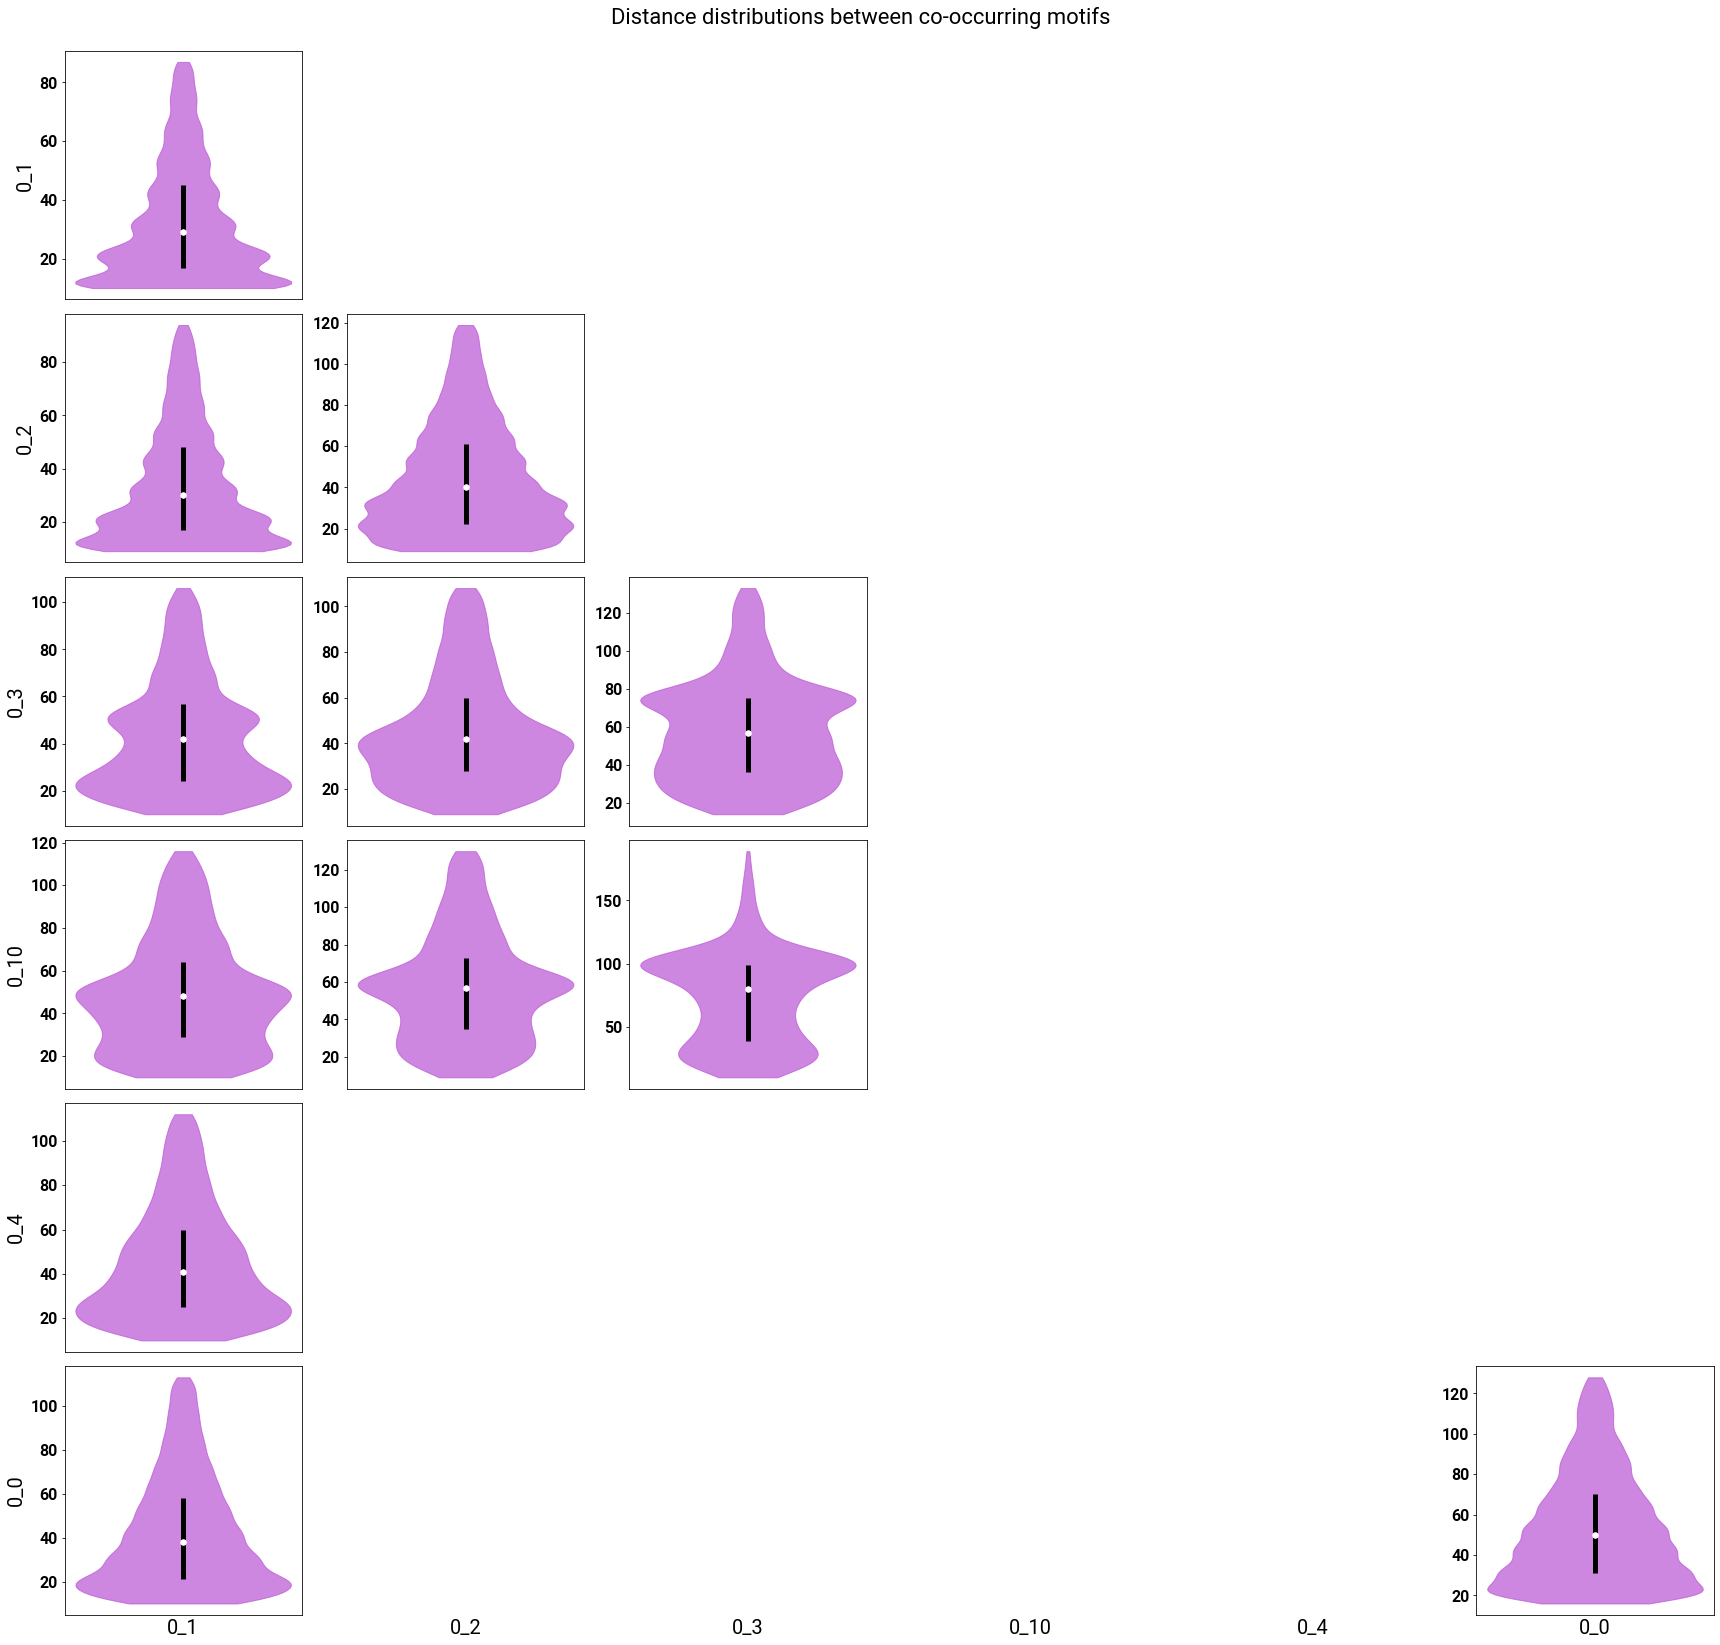

In [31]:
# Create the plot
fig, ax = plt.subplots(
    nrows=top_k, ncols=top_k, figsize=(top_k * 4, top_k * 4)
)
if type(ax) is not np.ndarray:
    ax = np.array([[ax]])

# Map motif key to axis index
key_to_index = dict(zip(motif_keys_ordered, np.arange(len(motif_keys_ordered))))

def clean_subplot(ax):
    # Do this instead of ax.axis("off"), which would also remove any
    # axis labels
    ax.set_yticks([])
    ax.set_xticks([])
    for orient in ("top", "bottom", "left", "right"):
        ax.spines[orient].set_visible(False)

# Create violins
for i in range(top_k):
    for j in range(i, top_k):
        key_1, key_2 = motif_keys_ordered[i], motif_keys_ordered[j]
        key_pair, rev_key_pair = (key_1, key_2), (key_2, key_1)
        axis_1, axis_2 = key_to_index[key_1], key_to_index[key_2]
        # Always plot lower triangle
        if axis_1 < axis_2:
            axis_1, axis_2 = axis_2, axis_1

        if key_pair in distance_dict or rev_key_pair in distance_dict:
            if rev_key_pair in distance_dict:
                key_pair = rev_key_pair
            dist = distance_dict[key_pair] 
            create_violin_plot(ax[axis_1, axis_2], [dist], ["mediumorchid"])
            ax[axis_1, axis_2].set_xticks([])  # Remove x-axis labels, as they don't mean much
            if axis_1 != axis_2:
                # If off diagonal, clean the axes of the symmetric cell
                clean_subplot(ax[axis_2, axis_1])
        else:
            clean_subplot(ax[axis_1, axis_2])
            clean_subplot(ax[axis_2, axis_1])

# Make motif labels
for i in range(top_k):
    ax[i, 0].set_ylabel(motif_keys_ordered[i])
    ax[-1, i].set_xlabel(motif_keys_ordered[i])

# Remove x-axis labels/ticks
ax[-1, -1].set_xticks([])
fig.suptitle("Distance distributions between co-occurring motifs")
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

plt.savefig(
    os.path.join(out_path, "coocurr_dist.svg"),
    format="svg"
)
plt.show()